In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Analyzing largest, second largest and average cluster size as a function of kT and secondary bond weight

In [7]:
data_path = '/Users/stephenthomas/Google Drive/Research/2017/LabNotes/Data/Jun5/bond_weight_study_exponent_inside/data'

[0.3, 0.5, 1, 10, 30, 40] [39.5, 78.890000000000001, 93.382500000000007, 96.939999999999998, 96.340000000000003, 95.335000000000008]
[0.3, 0.5, 1, 10, 30, 40] [25.879999999999999, 57.359999999999999, 88.327500000000001, 96.935000000000002, 95.974999999999994, 95.099999999999994]
[0.3, 0.5, 1, 10, 30, 40] [25.650000000000002, 46.195, 54.547500000000007, 95.704999999999998, 95.502499999999998, 94.972500000000011]
[0.3, 0.5, 1, 10, 30, 40] [25.082500000000003, 45.75, 54.172499999999999, 61.555000000000007, 92.774999999999991, 94.022499999999994]
[0.3, 0.5, 1, 10, 30, 40] [24.922499999999999, 45.710000000000001, 54.437500000000007, 54.884999999999998, 76.772499999999994, 86.752499999999998]


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


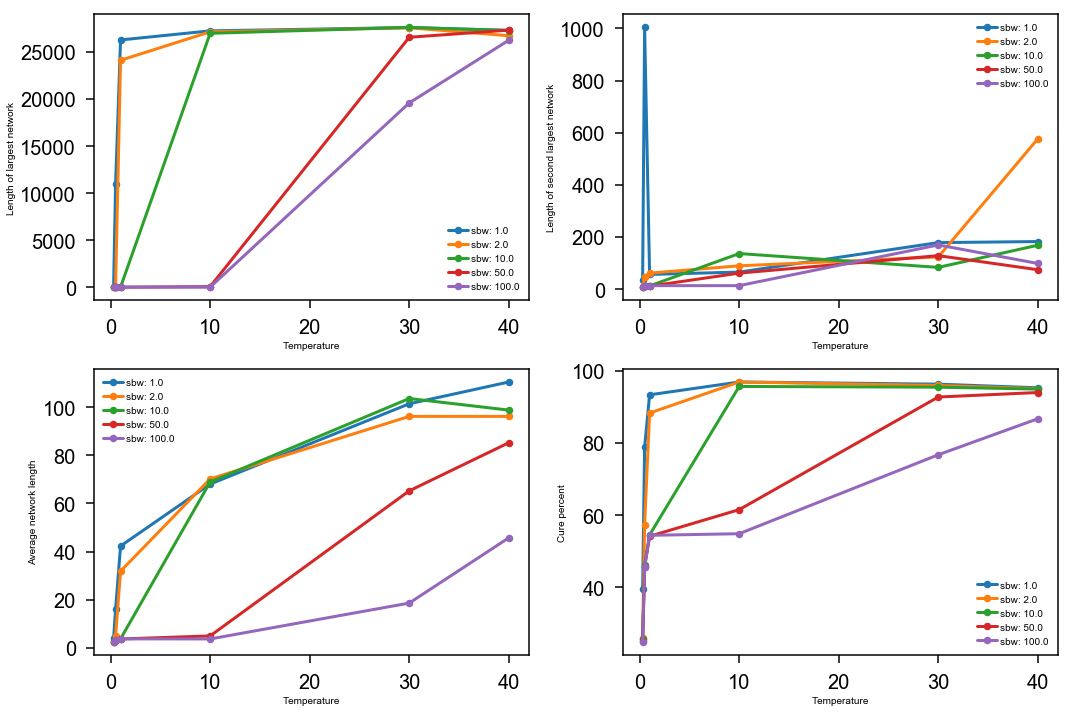

In [42]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('MyProject', data_path)


sbws = [1.0, 2.0, 10.0, 50.0, 100.0]
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
#fig, ax1 = plt.subplots(figsize=(15,10))
kTs=[0.3, 0.5, 1, 10, 30, 40]
    
for sbw in sbws:
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []
    cure_percent = []
    plt_kTs = []    
    for kT in kTs:
        jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
        for job in jobs:
            #print(job)
            job_status = get_status(job)
            #print(job.sp.temp_prof[-1][1])
            if job.sp.temp_prof[-1][1] ==kT:
                if job_status == 'job-computed':
                    #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
                    #print(job)
                    plt_kTs.append(job.sp.temp_prof[-1][1])
                    f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
                    t = gsd.hoomd.HOOMDTrajectory(f)
                    n_frames = len(t)
                    #print('total frames ',n_frames)
                    connected_components = []
                    last_frame = n_frames-1
                    snapshot = t[last_frame]
                    sim_box = snapshot.configuration.box
                    fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                    bonds = snapshot.bonds.group
                    G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                    G.graph
                    bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                    ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                    ab_bonds = [bonds[i] for i in ab_indices]
                    for bond in ab_bonds:
                        G.add_edge(bond[0],bond[1])
                    n_connected = nx.number_connected_components(G)
                    largest_cc = max(nx.connected_components(G), key=len)
                    connected_components.append(n_connected)
                    largest_networks.append(len(largest_cc))
                    sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
                    second_largest_networks.append(sorted_cc[1])
                    average_network_lens.append(np.mean(sorted_cc))

                    curing_data = np.genfromtxt(job.fn('bond_rank_hist.log'))
                    cure_percent.append(curing_data[-1,1])
                else:
                    print(job)
    ax1.plot(plt_kTs, largest_networks,linestyle='-',marker='o',label='sbw: {}'.format(sbw))
    ax2.plot(plt_kTs, second_largest_networks,linestyle='-',marker='o',label='sbw: {}'.format(sbw))
    ax3.plot(plt_kTs, average_network_lens,linestyle='-',marker='o',label='sbw: {}'.format(sbw))
    ax4.plot(plt_kTs, cure_percent,linestyle='-',marker='o',label='sbw: {}'.format(sbw))
    print(plt_kTs,cure_percent)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Length of largest network')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Length of second largest network')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Average network length')
ax4.set_xlabel('Temperature')
ax4.set_ylabel('Cure percent')
fig.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.savefig('inside_exponent.png'.format(sbw,kT))
plt.show()

### Analyzing distribution of cluster size as a function of time

[1, 100, 1000, 10000, 100000]


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2564 7664 7983 8009 8011 8011] 1 100


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


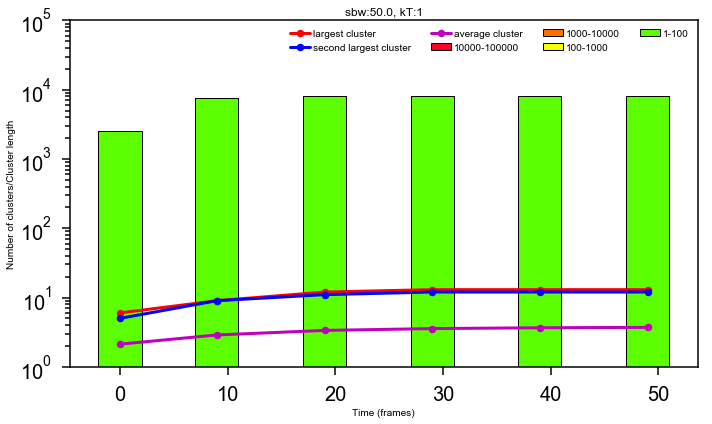

[0 0 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[ 0 17  0  1  4  1] 2 1000
[2562 3539 1090  712  543  454] 1 100


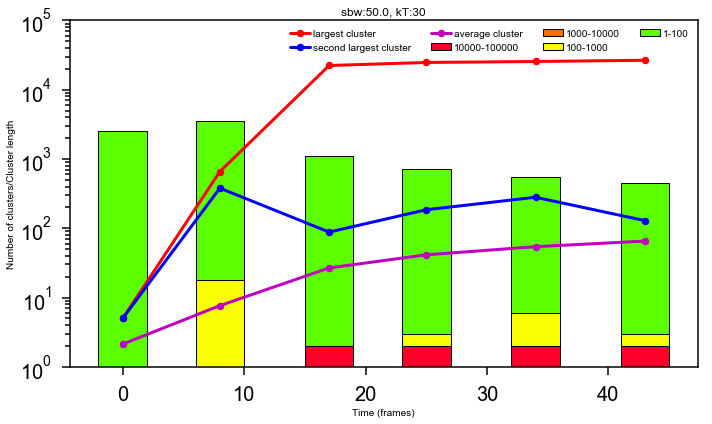

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2579 3913 4914 5603 6150 6560] 1 100


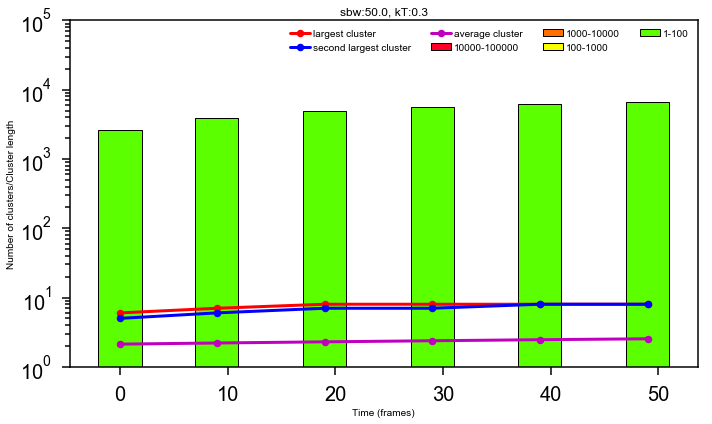

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 9 2 3 1 0] 2 1000
[2521 2283  825  530  402  346] 1 100


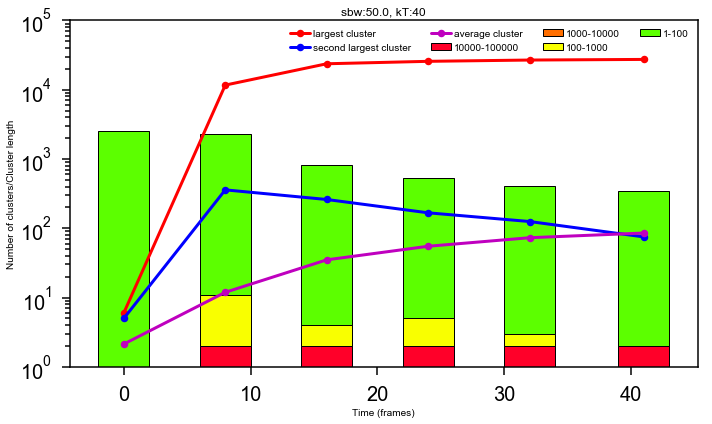

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2520 7765 7305 6857 6397 6015] 1 100


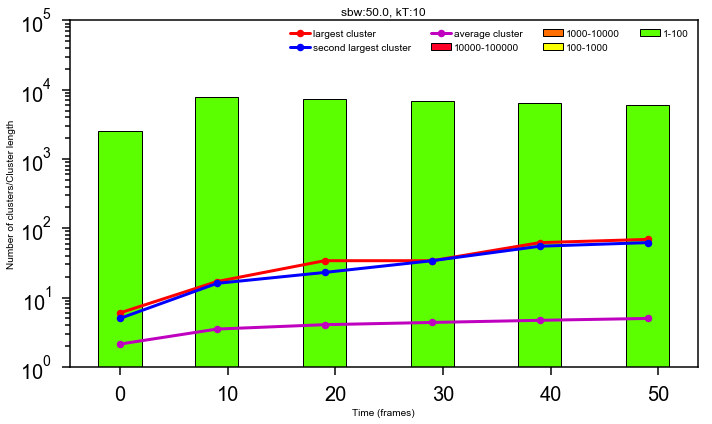

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2524 6032 7281 7712 7857 7910] 1 100


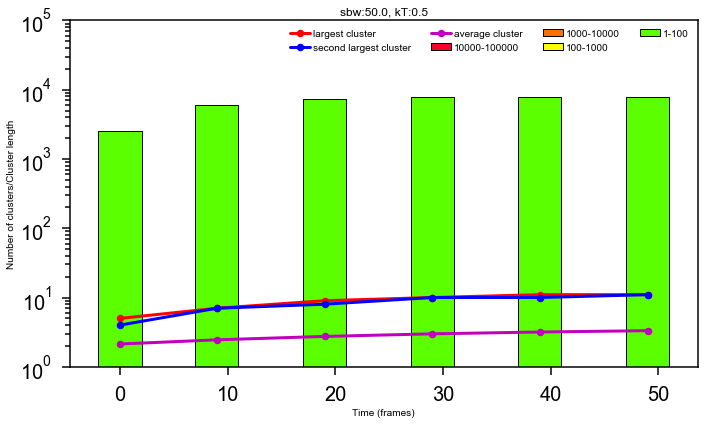

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2560 7604 7910 7933 7938 7938] 1 100


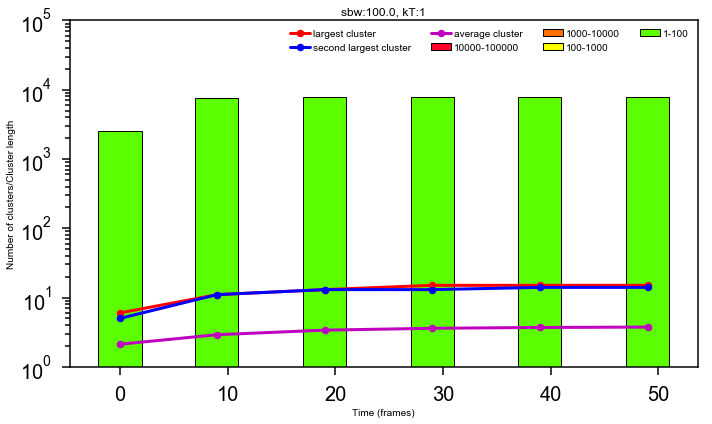

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2588 6065 7317 7721 7881 7935] 1 100


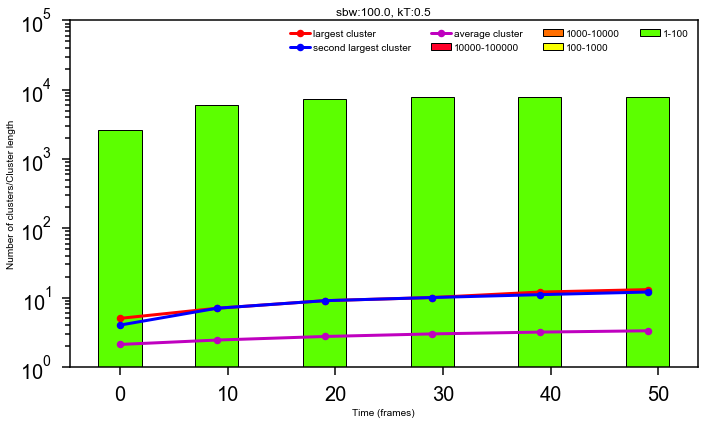

[0 0 0 1 1 1] 4 100000
[0 0 4 0 0 0] 3 10000
[0 1 8 2 0 0] 2 1000
[2541 5186 2312 1244  859  654] 1 100


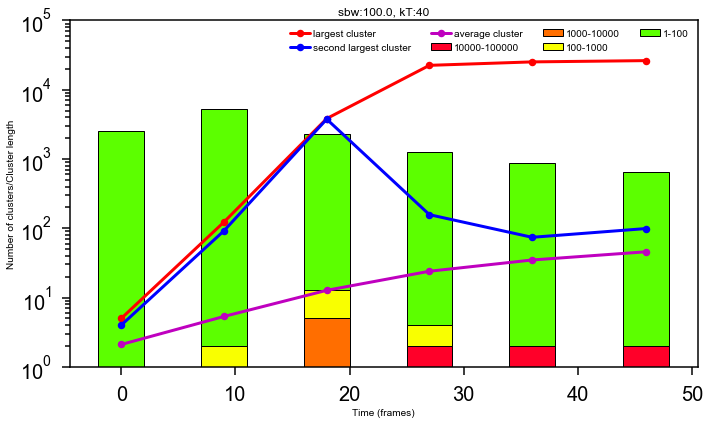

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2579 8051 8063 8060 8055 8051] 1 100


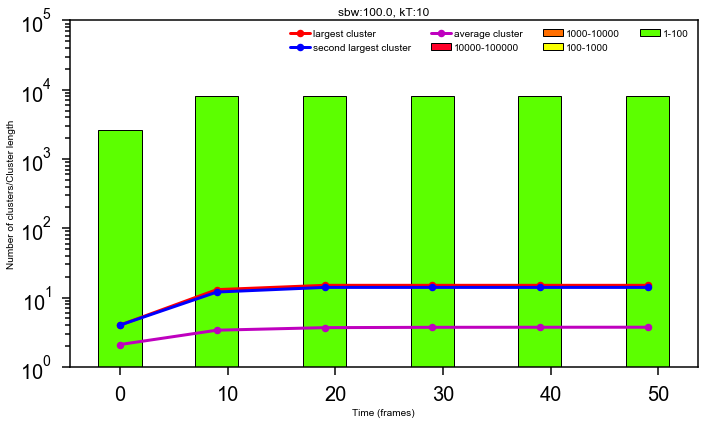

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2567 3797 4801 5537 6066 6488] 1 100


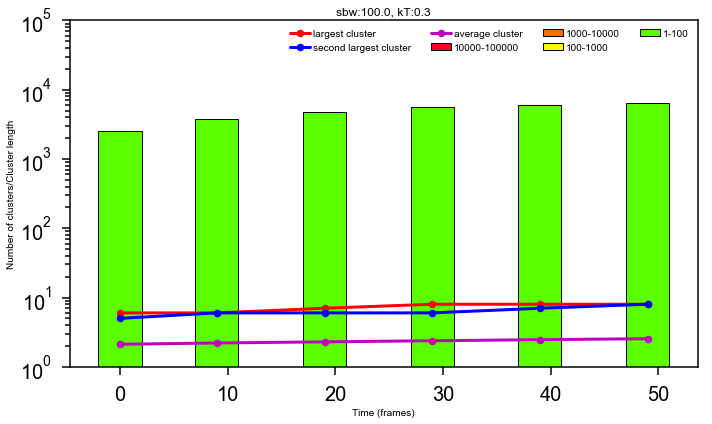

[0 0 0 0 1 1] 4 100000
[0 0 0 0 1 0] 3 10000
[ 0  0  2 34  9  4] 2 1000
[2595 6571 4684 3158 2207 1605] 1 100


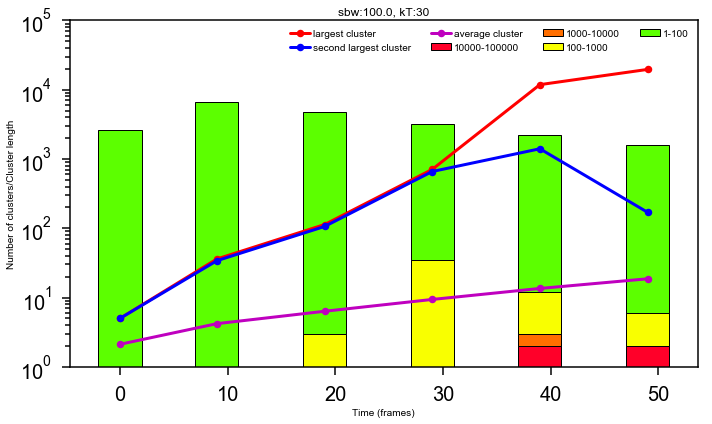

In [44]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
import math
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('MyProject', data_path)

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

sbws = [50.0, 100.0]
plt.figure(figsize=(15,10))
#bins = [1,5,10,50,100,1000,10000,20000,25000,27500,30000]#np.logspace(0.2,4.5,num=15)
bins = [1,100,1000,10000,100000]
#bins = np.logspace(0.,4.5,num=15)
print(bins)
#bins = np.linspace(0,40000,num=15)
bin_mids = []

NUM_COLORS = 10

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
#plt.color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
E_a = 1.0

for sbw in sbws:
    kTs=[]
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []

    jobs = project.find_jobs({'activation_energy':E_a, 'sec_bond_weight':sbw})
    for job in jobs:
        #print(job)
        job_status = get_status(job)
        #print(job_status)
        if job_status == 'job-computed' and job.get_id() !='6378fac29834215b7ae2ef2f9190e2ae':# and job.sp.temp_prof[-1][1]==1:
            #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
            #print(job)
            kT = job.sp.temp_prof[-1][1]
            kTs.append(kT)
            f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
            t = gsd.hoomd.HOOMDTrajectory(f)
            n_frames = len(t)
            #print('total frames ',n_frames)
            connected_components = []
            last_frame = n_frames-1
            time_steps = np.linspace(0,last_frame,6,endpoint=True,dtype=int)
            cluster_distributions = []
            largest_networks = []
            second_largest_networks = []
            average_network_lens = []
            for ts in time_steps:
                #print((ts))
                snapshot = t[int(ts)]
                sim_box = snapshot.configuration.box
                fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                bonds = snapshot.bonds.group
                G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                ab_bonds = [bonds[i] for i in ab_indices]
                for bond in ab_bonds:
                    G.add_edge(bond[0],bond[1])
                sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=False)]
                hist,bin_edges = np.histogram(sorted_cc,bins=bins)
                cluster_distributions.append(hist)
                largest_networks.append(sorted_cc[-1])
                second_largest_networks.append(sorted_cc[-2])
                average_network_lens.append(np.mean(sorted_cc))
            
            distribs = np.array(cluster_distributions)
            fig = plt.figure(figsize=(10,6))
            width=4
            ax = fig.add_subplot(111)
            ax.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
            bin_mids=[]
            for i,bin_edge in enumerate(bin_edges):
                if i>0:
                    bin_mids.append((bin_edge+bins[i-1])/2.)
            #print('bin_edges\n',bin_edges)
            #print('distribs\n',distribs)
            for i,bin_edge in reversed(list(enumerate(bin_edges))):
                #print(distribs[:,i],i)
                if i>0:
                    label = '{}-{}'.format(int(bin_edges[i-1]),int(bin_edges[i]))
                    #print('label is ',label)
                    dist = distribs[:,i-1]

                    print(dist,i,bin_edge)
                    if i == len(bin_edges)-1:
                        slice_sum = np.ones_like(dist)
                        plt.bar(time_steps, dist, bottom=slice_sum, edgecolor='black',width=width,label=label)
                        slice_sum += dist
                    else:
                        #if i == 1:
                        #    print(dist)
                        
                        plt.bar(time_steps, dist, bottom=slice_sum, edgecolor='black',width=width,label=label)
                        slice_sum += dist
            plt.plot(time_steps, largest_networks,color='r',linestyle='-',marker='o',label='largest cluster')
            plt.plot(time_steps, second_largest_networks,color='b',linestyle='-',marker='o',label='second largest cluster')
            plt.plot(time_steps, average_network_lens,color='m',linestyle='-',marker='o',label='average cluster')
                #print(slice_sum)
            plt.legend(ncol=4)
            plt.xlabel('Time (frames)')
            plt.ylabel('Number of clusters/Cluster length')
            
            x1,x2,y1,y2 = plt.axis()
            plt.axis((x1,x2,1.0,100000.0))
            #plt.xscale('log')
            plt.yscale('log')
            k2_k1 = math.exp(E_a*(sbw-1)/kT)
            plt.title('sbw:{}, kT:{}'.format(sbw,kT))
            plt.savefig('sbw_inside_e_{}_kT_{}.png'.format(sbw,kT))
            plt.show()

final state points: 5040001.0 time step, 0.5 kT, status:job-computed
2a2b4a9674ea7cddc6264c77670f8005
final state points: 5040001.0 time step, 30 kT, status:job-computed
3cc7128bf79f3a2de2df86b6def2e77e
final state points: 5040001.0 time step, 1 kT, status:job-computed
e942bc722cbfa8da62be514fce9b8f67
final state points: 5040001.0 time step, 0.3 kT, status:job-computed
fda2b5caff0c65a5d9d1d80e32194b7d
final state points: 5040001.0 time step, 40 kT, status:job-computed
043212aafa20a416caf679f46859d349
final state points: 5040001.0 time step, 10 kT, status:job-computed
44774984cc3df75b875e091a91fce7ea


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


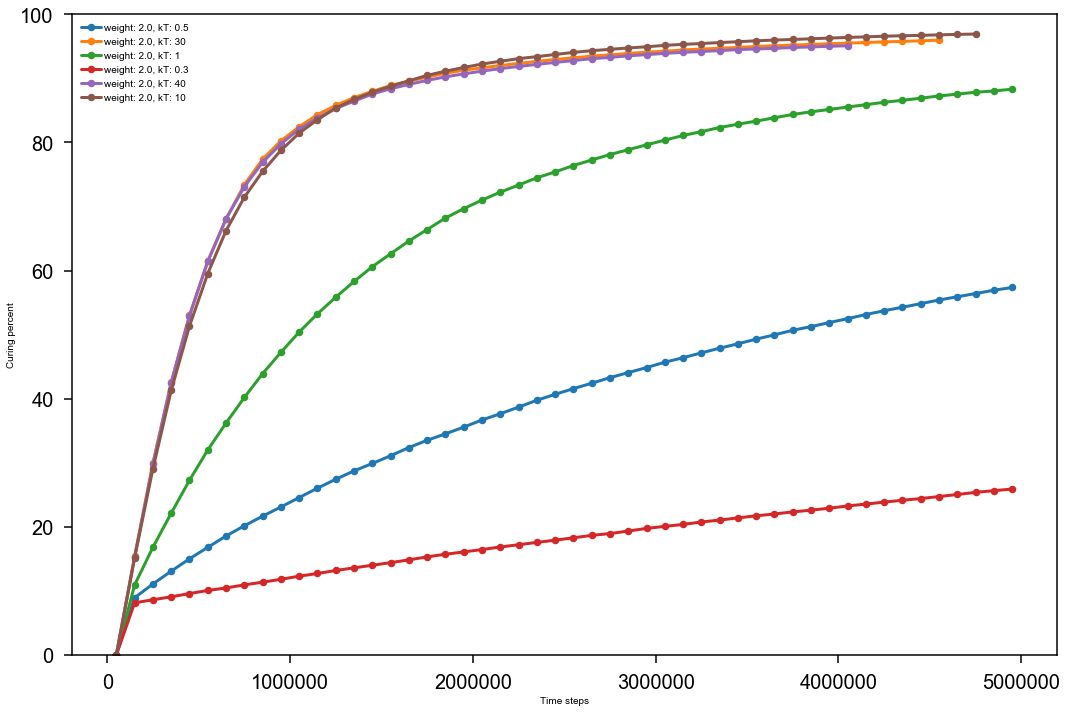

In [37]:
import signac
import matplotlib.pyplot as plt
%matplotlib inline

project = signac.init_project('MyProject', data_path)
sbw=2
jobs = project.find_jobs({'activation_energy':1,'sec_bond_weight':sbw})

plt.figure(figsize=(15,10))
for job in jobs:
    job_status = get_status(job)
    if job_status == 'job-computed':
    #if job.sp.temp_prof[-1][0]== 9030001.0 and (job.sp.temp_prof[-1][1] == 6 or job.sp.temp_prof[-1][1] == 1):# and (job_status == 'job-computed'):
        print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
        print(job)
        data = np.genfromtxt(job.fn('bond_rank_hist.log'))
        #print(data)
        legend = 'weight: {}, kT: {}'.format(job.sp.sec_bond_weight,job.sp.temp_prof[-1][1])
        plt.plot(data[:,0],data[:,1],marker='o',label=legend)
        #plt.plot(data[:,0],data[:,2],marker='o',label='primary epoxy')
        #plt.plot(data[:,0],data[:,3],marker='o',label='secondary epoxy')
        #plt.plot(data[:,0],data[:,4],marker='o',label='ternary epoxy')
        #plt.plot(data[:,0],data[:,5],marker='o',label='quatenary epoxy')

#random.seed(12345)
#kTs = [1]
#activation_energy = 1
#weights = [1]
#for weight in weights:
#    legend = 'weight:{}'.format(weight)
#    #plot_bonding(kTs, activation_energy,no_weights=False,time=5e6,show_all=False,weight=weight,show_figure=False,legend=legend)


plt.xlabel('Time steps')
plt.ylabel('Curing percent')
plt.ylim(0,100)
plt.legend()
plt.show()

In [39]:
1/0.0097

103.09278350515464